# Data seimbang dan tanpa fine-tuning

In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import tensorflow
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_benih = '/content/drive/My Drive/Penelitian/Dataset/'

In [ ]:
kelas = ['haploid', 'diploid']
kelas

['haploid', 'diploid']

In [ ]:
def get_data(data_dir):
    size = (224,224)
    label = 0
    x = []
    y = []
    for folder in kelas:
        print("Loading {}".format(data_dir+folder))
        for pic in tqdm(glob.glob(data_dir + folder + '/*')):
            im = cv2.imread(pic)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (size))
            im = np.array(im)
            x.append(im)
            y.append(label)
        label+=1
    x = np.array(x, dtype = 'float32')
    y = np.array(y, dtype = 'int32')
    return x,y

In [ ]:
x_train, y_train = get_data(path_benih + 'train/')
x_test, y_test = get_data(path_benih + 'test/')

Loading /content/drive/My Drive/Penelitian/Dataset/train/haploid


100%|██████████| 984/984 [00:15<00:00, 63.69it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/train/diploid


100%|██████████| 1416/1416 [00:23<00:00, 61.50it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/test/haploid


100%|██████████| 246/246 [00:05<00:00, 48.12it/s]


Loading /content/drive/My Drive/Penelitian/Dataset/test/diploid


100%|██████████| 354/354 [00:06<00:00, 54.83it/s] 


In [ ]:
x_train/=255.
x_test/=255.

In [ ]:
len(x_train)+len(x_test)

3000

In [ ]:
def balanced(y_train):
  labels_count = np.unique(y_train, return_counts=True)
  plt.figure(figsize=(8,12))
  plt.rcParams['font.size'] = 18
  plt.pie(labels_count[1],
          labels=kelas,
          autopct='%1.1f%%')
  plt.title('Perbandingan Haploid dan Diploid', size=23)
  plt.show()

#### Training Data

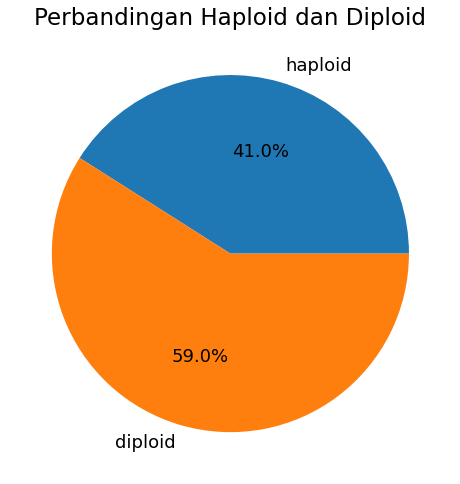

In [ ]:
balanced(y_train)

In [ ]:
rus = RandomUnderSampler(random_state=42)
n_sample, height, width, channel = x_train.shape

x_train, y_train = rus.fit_resample(
    x_train.reshape((n_sample, height*width*channel)), y_train)

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 224, 224, 3))

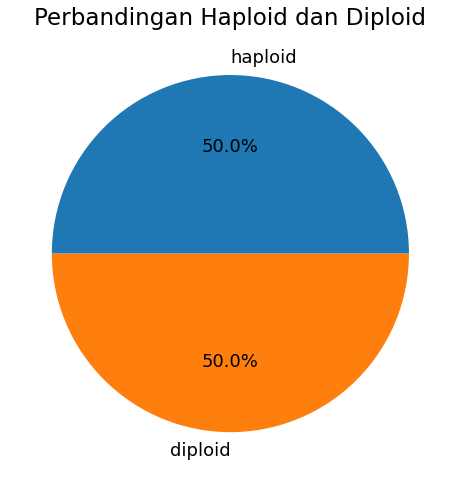

In [ ]:
balanced(y_train)

#### Testing Data

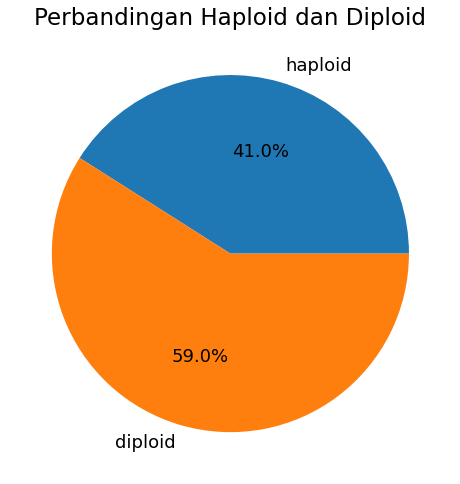

In [ ]:
balanced(y_test)

In [ ]:
rus = RandomUnderSampler(random_state=42)
n_sample, height, width, channel = x_test.shape

x_test, y_test = rus.fit_resample(
    x_test.reshape((n_sample, height*width*channel)), y_test)

In [ ]:
x_test = x_test.reshape((x_test.shape[0], 224, 224, 3))

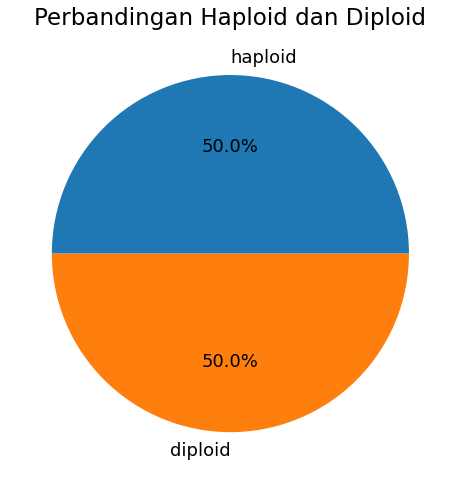

In [ ]:
balanced(y_test)

In [ ]:
len(x_train)+len(x_test)

2460

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [ ]:
vgg = VGG19(input_shape = (224, 224, 3), include_top=False, weights="imagenet")
vgg.trainable = False
vgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
def arsitektur():
  x=Flatten()(vgg.output)
  x=Dense(1024, activation='relu')(x)
  x=Dropout(0.5)(x)
  x=Dense(1024, activation='relu')(x)
  x=Dropout(0.5)(x)
  prediksi=Dense(len(kelas), activation='softmax')(x)
  model=Model(inputs=vgg.input, outputs=prediksi)
  
  return model

In [ ]:
model = arsitektur()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def get_model_name(k):
  return 'model_'+str(k)

In [ ]:
akurasi_val_data=[]
AUC=[]
CV=[]
waktu=[]

LOSS=[]
VAL_LOSS=[]
ACCURACY=[]
VAL_ACCURACY=[]

fold_var = 1
max_epoch = 64
mini_batch = 32
lr = 0.0001

save_dir = '/content/drive/My Drive/Penelitian/save_models/percobaan_3/'

In [ ]:
kf = StratifiedKFold(n_splits=5)
for train_index, val_index in kf.split(x_train, y_train):
  print("---------- FOLD KE- {} ----------".format(fold_var))
  x_training, y_training = x_train[train_index], y_train[train_index]
  x_validasi, y_validasi = x_train[val_index], y_train[val_index]

  y_training = to_categorical(y_training)   
  y_validasi = to_categorical(y_validasi)

  model = arsitektur()
  model.compile(optimizer=Adam(learning_rate=lr), 
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # min_delta (perubahan minimal), patience (jumlah epoch tanpa perbaikan)
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='auto')
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var),
                               monitor='val_accuracy', verbose=1,
                               save_best_only=True, mode='max')
  callback_list = [early_stop, checkpoint]

  start = datetime.datetime.now()
  hist = model.fit(x_training, y_training, 
                   epochs=max_epoch,
                   batch_size=mini_batch,
                   callbacks=callback_list,
                   validation_data = (x_validasi, y_validasi))
  end = datetime.datetime.now()
  jam = end - start

  model = load_model(save_dir+"model_"+str(fold_var))

  predict = model.predict(x_validasi)
  predict = np.argmax(predict, axis=1)
  labels = np.argmax(y_validasi, axis=1)
  print(classification_report(labels, predict, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))
  print('Waktu Pelatihan Data : ', jam, '\n\n')
  acc = accuracy_score(labels, predict)
  auc = roc_auc_score(labels, predict)

  waktu.append(jam)
  akurasi_val_data.append(acc)
  AUC.append(auc)
  LOSS.append(hist.history['loss'])
  ACCURACY.append(hist.history['accuracy'])
  VAL_LOSS.append(hist.history['val_loss'])
  VAL_ACCURACY.append(hist.history['val_accuracy'])
  CV.append('CV-'+str(fold_var))

  clear_session()
  fold_var+=1

---------- FOLD KE- 1 ----------
Epoch 1/64
50/50 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.5737
Epoch 1: val_accuracy improved from -inf to 0.73858, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_1


50/50 [==============================] - 28s 390ms/step - loss: 0.7749 - accuracy: 0.5737 - val_loss: 0.5736 - val_accuracy: 0.7386
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.6970
Epoch 2: val_accuracy improved from 0.73858 to 0.80457, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_1


50/50 [==============================] - 15s 305ms/step - loss: 0.6026 - accuracy: 0.6970 - val_loss: 0.4811 - val_accuracy: 0.8046
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.5247 - accuracy: 0.7637
Epoch 3: val_accuracy improved from 0.80457 to 0.81472, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_1


50/50 [==============================] - 16s 325ms/step - loss: 0.5247 - accuracy: 0.7637 - val_loss: 0.4435 - val_accuracy: 0.8147
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.7903
Epoch 4: val_accuracy improved from 0.81472 to 0.82487, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_1


50/50 [==============================] - 16s 315ms/step - loss: 0.4826 - accuracy: 0.7903 - val_loss: 0.4195 - val_accuracy: 0.8249
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.8005
Epoch 5: val_accuracy improved from 0.82487 to 0.84010, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_1


50/50 [==============================] - 16s 328ms/step - loss: 0.4524 - accuracy: 0.8005 - val_loss: 0.3975 - val_accuracy: 0.8401
Epoch 6/64
50/50 [==============================] - ETA: 0s - loss: 0.4332 - accuracy: 0.8005
Epoch 6: val_accuracy improved from 0.84010 to 0.84264, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_1


50/50 [==============================] - 16s 314ms/step - loss: 0.4332 - accuracy: 0.8005 - val_loss: 0.3788 - val_accuracy: 0.8426
Epoch 7/64
50/50 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.8132
Epoch 7: val_accuracy did not improve from 0.84264
50/50 [==============================] - 11s 224ms/step - loss: 0.4193 - accuracy: 0.8132 - val_loss: 0.3915 - val_accuracy: 0.8426
Epoch 8/64
50/50 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.8310
Epoch 8: val_accuracy did not improve from 0.84264
50/50 [==============================] - 11s 226ms/step - loss: 0.3855 - accuracy: 0.8310 - val_loss: 0.4207 - val_accuracy: 0.8147
Epoch 9/64
50/50 [==============================] - ETA: 0s - loss: 0.3577 - accuracy: 0.8393
Epoch 9: val_accuracy did not improve from 0.84264
50/50 [==============================] - 11s 228ms/step - loss: 0.3577 - accuracy: 0.8393 - val_loss: 0.3884 - val_accuracy: 0.8299
Epoch 10/64
50/50 [==================

50/50 [==============================] - 15s 310ms/step - loss: 0.3535 - accuracy: 0.8424 - val_loss: 0.3459 - val_accuracy: 0.8629
Epoch 11/64
50/50 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8666
Epoch 11: val_accuracy did not improve from 0.86294
50/50 [==============================] - 11s 225ms/step - loss: 0.3228 - accuracy: 0.8666 - val_loss: 0.3477 - val_accuracy: 0.8604
Epoch 12/64
50/50 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8545
Epoch 12: val_accuracy did not improve from 0.86294
50/50 [==============================] - 11s 225ms/step - loss: 0.3466 - accuracy: 0.8545 - val_loss: 0.3507 - val_accuracy: 0.8553
Epoch 13/64
50/50 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8672
Epoch 13: val_accuracy did not improve from 0.86294
50/50 [==============================] - 11s 225ms/step - loss: 0.3198 - accuracy: 0.8672 - val_loss: 0.3517 - val_accuracy: 0.8426
Epoch 14/64
50/50 [============

50/50 [==============================] - 16s 315ms/step - loss: 0.2966 - accuracy: 0.8653 - val_loss: 0.3394 - val_accuracy: 0.8706
Epoch 15/64
50/50 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8761
Epoch 15: val_accuracy did not improve from 0.87056
50/50 [==============================] - 11s 225ms/step - loss: 0.3015 - accuracy: 0.8761 - val_loss: 0.3512 - val_accuracy: 0.8579
Epoch 16/64
50/50 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9034
Epoch 16: val_accuracy did not improve from 0.87056
50/50 [==============================] - 11s 225ms/step - loss: 0.2731 - accuracy: 0.9034 - val_loss: 0.3459 - val_accuracy: 0.8629
Epoch 17/64
50/50 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.8983
Epoch 17: val_accuracy did not improve from 0.87056
50/50 [==============================] - 11s 225ms/step - loss: 0.2585 - accuracy: 0.8983 - val_loss: 0.3444 - val_accuracy: 0.8680
Epoch 18/64
50/50 [============

50/50 [==============================] - 17s 326ms/step - loss: 0.7555 - accuracy: 0.6080 - val_loss: 0.6013 - val_accuracy: 0.6954
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.7211
Epoch 2: val_accuracy improved from 0.69543 to 0.71066, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_2


50/50 [==============================] - 17s 342ms/step - loss: 0.5863 - accuracy: 0.7211 - val_loss: 0.5650 - val_accuracy: 0.7107
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.7637
Epoch 3: val_accuracy improved from 0.71066 to 0.76142, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_2


50/50 [==============================] - 16s 323ms/step - loss: 0.5150 - accuracy: 0.7637 - val_loss: 0.5014 - val_accuracy: 0.7614
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.4760 - accuracy: 0.7732
Epoch 4: val_accuracy improved from 0.76142 to 0.80711, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_2


50/50 [==============================] - 16s 317ms/step - loss: 0.4760 - accuracy: 0.7732 - val_loss: 0.4616 - val_accuracy: 0.8071
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.7935
Epoch 5: val_accuracy did not improve from 0.80711
50/50 [==============================] - 11s 226ms/step - loss: 0.4552 - accuracy: 0.7935 - val_loss: 0.4378 - val_accuracy: 0.7893
Epoch 6/64
50/50 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.8158
Epoch 6: val_accuracy did not improve from 0.80711
50/50 [==============================] - 11s 225ms/step - loss: 0.4144 - accuracy: 0.8158 - val_loss: 0.4560 - val_accuracy: 0.7919
Epoch 7/64
50/50 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8247
Epoch 7: val_accuracy improved from 0.80711 to 0.81980, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_2


50/50 [==============================] - 16s 318ms/step - loss: 0.4033 - accuracy: 0.8247 - val_loss: 0.4010 - val_accuracy: 0.8198
Epoch 8/64
50/50 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.8393
Epoch 8: val_accuracy did not improve from 0.81980
50/50 [==============================] - 11s 225ms/step - loss: 0.3804 - accuracy: 0.8393 - val_loss: 0.4092 - val_accuracy: 0.8147
Epoch 9/64
50/50 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.8424
Epoch 9: val_accuracy improved from 0.81980 to 0.84264, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_2


50/50 [==============================] - 15s 307ms/step - loss: 0.3652 - accuracy: 0.8424 - val_loss: 0.3852 - val_accuracy: 0.8426
Epoch 10/64
50/50 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8507
Epoch 10: val_accuracy did not improve from 0.84264
50/50 [==============================] - 11s 225ms/step - loss: 0.3292 - accuracy: 0.8507 - val_loss: 0.3983 - val_accuracy: 0.8274
Epoch 11/64
50/50 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.8634
Epoch 11: val_accuracy did not improve from 0.84264
50/50 [==============================] - 11s 225ms/step - loss: 0.3242 - accuracy: 0.8634 - val_loss: 0.3892 - val_accuracy: 0.8350
Epoch 12/64
50/50 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8710
Epoch 12: val_accuracy improved from 0.84264 to 0.85279, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_2


50/50 [==============================] - 16s 316ms/step - loss: 0.3127 - accuracy: 0.8710 - val_loss: 0.3610 - val_accuracy: 0.8528
Epoch 13/64
50/50 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8723
Epoch 13: val_accuracy did not improve from 0.85279
50/50 [==============================] - 11s 225ms/step - loss: 0.3150 - accuracy: 0.8723 - val_loss: 0.3601 - val_accuracy: 0.8376
Epoch 14/64
50/50 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.8850
Epoch 14: val_accuracy improved from 0.85279 to 0.86041, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_2


50/50 [==============================] - 15s 311ms/step - loss: 0.2895 - accuracy: 0.8850 - val_loss: 0.3423 - val_accuracy: 0.8604
Epoch 15/64
50/50 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8856
Epoch 15: val_accuracy did not improve from 0.86041
50/50 [==============================] - 11s 225ms/step - loss: 0.2856 - accuracy: 0.8856 - val_loss: 0.3577 - val_accuracy: 0.8401
Epoch 16/64
50/50 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.9003
Epoch 16: val_accuracy did not improve from 0.86041
50/50 [==============================] - 11s 228ms/step - loss: 0.2583 - accuracy: 0.9003 - val_loss: 0.3605 - val_accuracy: 0.8604
Epoch 17/64
50/50 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.8990
Epoch 17: val_accuracy did not improve from 0.86041
50/50 [==============================] - 11s 227ms/step - loss: 0.2574 - accuracy: 0.8990 - val_loss: 0.3406 - val_accuracy: 0.8553
Epoch 18/64
50/50 [============

50/50 [==============================] - 15s 311ms/step - loss: 0.2472 - accuracy: 0.9009 - val_loss: 0.3306 - val_accuracy: 0.8680
Epoch 20/64
50/50 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.8952
Epoch 20: val_accuracy did not improve from 0.86802
50/50 [==============================] - 11s 225ms/step - loss: 0.2378 - accuracy: 0.8952 - val_loss: 0.3584 - val_accuracy: 0.8604
Epoch 21/64
50/50 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9199
Epoch 21: val_accuracy improved from 0.86802 to 0.87817, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_2


50/50 [==============================] - 16s 318ms/step - loss: 0.2239 - accuracy: 0.9199 - val_loss: 0.3222 - val_accuracy: 0.8782
Epoch 22/64
50/50 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9136
Epoch 22: val_accuracy did not improve from 0.87817
50/50 [==============================] - 11s 226ms/step - loss: 0.2259 - accuracy: 0.9136 - val_loss: 0.4048 - val_accuracy: 0.8325
Epoch 23/64
50/50 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9161
Epoch 23: val_accuracy did not improve from 0.87817
50/50 [==============================] - 11s 226ms/step - loss: 0.2120 - accuracy: 0.9161 - val_loss: 0.3416 - val_accuracy: 0.8655
Epoch 24/64
50/50 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9219
Epoch 24: val_accuracy did not improve from 0.87817
50/50 [==============================] - 11s 225ms/step - loss: 0.2003 - accuracy: 0.9219 - val_loss: 0.4313 - val_accuracy: 0.8452
Epoch 25/64
50/50 [============

50/50 [==============================] - 15s 310ms/step - loss: 0.1869 - accuracy: 0.9301 - val_loss: 0.3258 - val_accuracy: 0.8807
Epoch 30/64
50/50 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9307
Epoch 30: val_accuracy did not improve from 0.88071
50/50 [==============================] - 11s 225ms/step - loss: 0.1884 - accuracy: 0.9307 - val_loss: 0.3341 - val_accuracy: 0.8706
Epoch 31/64
50/50 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9358
Epoch 31: val_accuracy did not improve from 0.88071
50/50 [==============================] - 11s 225ms/step - loss: 0.1595 - accuracy: 0.9358 - val_loss: 0.3989 - val_accuracy: 0.8325
Epoch 32/64
50/50 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9301
Epoch 32: val_accuracy did not improve from 0.88071
50/50 [==============================] - 11s 227ms/step - loss: 0.1815 - accuracy: 0.9301 - val_loss: 0.3498 - val_accuracy: 0.8528
Epoch 33/64
50/50 [============

50/50 [==============================] - 18s 345ms/step - loss: 0.7593 - accuracy: 0.6118 - val_loss: 0.5785 - val_accuracy: 0.7132
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.7058
Epoch 2: val_accuracy improved from 0.71320 to 0.75381, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_3


50/50 [==============================] - 16s 330ms/step - loss: 0.5978 - accuracy: 0.7058 - val_loss: 0.5087 - val_accuracy: 0.7538
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7554
Epoch 3: val_accuracy improved from 0.75381 to 0.79188, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_3


50/50 [==============================] - 17s 332ms/step - loss: 0.5169 - accuracy: 0.7554 - val_loss: 0.4711 - val_accuracy: 0.7919
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.7827
Epoch 4: val_accuracy improved from 0.79188 to 0.79949, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_3


50/50 [==============================] - 16s 325ms/step - loss: 0.4800 - accuracy: 0.7827 - val_loss: 0.4476 - val_accuracy: 0.7995
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.7986
Epoch 5: val_accuracy improved from 0.79949 to 0.80711, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_3


50/50 [==============================] - 17s 347ms/step - loss: 0.4444 - accuracy: 0.7986 - val_loss: 0.4298 - val_accuracy: 0.8071
Epoch 6/64
50/50 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8056
Epoch 6: val_accuracy did not improve from 0.80711
50/50 [==============================] - 11s 225ms/step - loss: 0.4396 - accuracy: 0.8056 - val_loss: 0.4288 - val_accuracy: 0.8046
Epoch 7/64
50/50 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8304
Epoch 7: val_accuracy improved from 0.80711 to 0.81980, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_3


50/50 [==============================] - 15s 307ms/step - loss: 0.3995 - accuracy: 0.8304 - val_loss: 0.4251 - val_accuracy: 0.8198
Epoch 8/64
50/50 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8443
Epoch 8: val_accuracy did not improve from 0.81980
50/50 [==============================] - 11s 225ms/step - loss: 0.3950 - accuracy: 0.8443 - val_loss: 0.4228 - val_accuracy: 0.7995
Epoch 9/64
50/50 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8405
Epoch 9: val_accuracy improved from 0.81980 to 0.83503, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_3


50/50 [==============================] - 16s 315ms/step - loss: 0.3682 - accuracy: 0.8405 - val_loss: 0.3972 - val_accuracy: 0.8350
Epoch 10/64
50/50 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8456
Epoch 10: val_accuracy did not improve from 0.83503
50/50 [==============================] - 11s 226ms/step - loss: 0.3740 - accuracy: 0.8456 - val_loss: 0.5040 - val_accuracy: 0.7386
Epoch 11/64
50/50 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8494
Epoch 11: val_accuracy did not improve from 0.83503
50/50 [==============================] - 11s 226ms/step - loss: 0.3574 - accuracy: 0.8494 - val_loss: 0.4136 - val_accuracy: 0.8325
Epoch 12/64
50/50 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8640
Epoch 12: val_accuracy did not improve from 0.83503
50/50 [==============================] - 11s 225ms/step - loss: 0.3158 - accuracy: 0.8640 - val_loss: 0.3971 - val_accuracy: 0.8122
Epoch 13/64
50/50 [============

50/50 [==============================] - 15s 306ms/step - loss: 0.2679 - accuracy: 0.8895 - val_loss: 0.3903 - val_accuracy: 0.8629
Epoch 18/64
50/50 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8875
Epoch 18: val_accuracy did not improve from 0.86294
50/50 [==============================] - 11s 225ms/step - loss: 0.2628 - accuracy: 0.8875 - val_loss: 0.3608 - val_accuracy: 0.8553
Epoch 19/64
50/50 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9028
Epoch 19: val_accuracy did not improve from 0.86294
50/50 [==============================] - 11s 226ms/step - loss: 0.2425 - accuracy: 0.9028 - val_loss: 0.4644 - val_accuracy: 0.8274
Epoch 20/64
50/50 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.8799
Epoch 20: val_accuracy did not improve from 0.86294
50/50 [==============================] - 11s 229ms/step - loss: 0.2670 - accuracy: 0.8799 - val_loss: 0.3633 - val_accuracy: 0.8452
Epoch 21/64
50/50 [============

50/50 [==============================] - 19s 371ms/step - loss: 0.7668 - accuracy: 0.5765 - val_loss: 0.5339 - val_accuracy: 0.7761
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.6068 - accuracy: 0.7035
Epoch 2: val_accuracy improved from 0.77608 to 0.78880, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_4


50/50 [==============================] - 16s 326ms/step - loss: 0.6068 - accuracy: 0.7035 - val_loss: 0.4753 - val_accuracy: 0.7888
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.7568
Epoch 3: val_accuracy improved from 0.78880 to 0.80662, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_4


50/50 [==============================] - 17s 341ms/step - loss: 0.5209 - accuracy: 0.7568 - val_loss: 0.4444 - val_accuracy: 0.8066
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.8013
Epoch 4: val_accuracy did not improve from 0.80662
50/50 [==============================] - 11s 225ms/step - loss: 0.4591 - accuracy: 0.8013 - val_loss: 0.4267 - val_accuracy: 0.8015
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.8044
Epoch 5: val_accuracy improved from 0.80662 to 0.81425, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_4


50/50 [==============================] - 15s 311ms/step - loss: 0.4413 - accuracy: 0.8044 - val_loss: 0.4137 - val_accuracy: 0.8142
Epoch 6/64
50/50 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8254
Epoch 6: val_accuracy did not improve from 0.81425
50/50 [==============================] - 11s 225ms/step - loss: 0.4081 - accuracy: 0.8254 - val_loss: 0.4219 - val_accuracy: 0.8092
Epoch 7/64
50/50 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8184
Epoch 7: val_accuracy improved from 0.81425 to 0.82443, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_4


50/50 [==============================] - 16s 313ms/step - loss: 0.3977 - accuracy: 0.8184 - val_loss: 0.3880 - val_accuracy: 0.8244
Epoch 8/64
50/50 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8483
Epoch 8: val_accuracy did not improve from 0.82443
50/50 [==============================] - 11s 226ms/step - loss: 0.3624 - accuracy: 0.8483 - val_loss: 0.3888 - val_accuracy: 0.8193
Epoch 9/64
50/50 [==============================] - ETA: 0s - loss: 0.3514 - accuracy: 0.8514
Epoch 9: val_accuracy improved from 0.82443 to 0.82952, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_4


50/50 [==============================] - 15s 306ms/step - loss: 0.3514 - accuracy: 0.8514 - val_loss: 0.3787 - val_accuracy: 0.8295
Epoch 10/64
50/50 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8590
Epoch 10: val_accuracy improved from 0.82952 to 0.83206, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_4


50/50 [==============================] - 16s 328ms/step - loss: 0.3358 - accuracy: 0.8590 - val_loss: 0.3752 - val_accuracy: 0.8321
Epoch 11/64
50/50 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8819
Epoch 11: val_accuracy improved from 0.83206 to 0.83969, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_4


50/50 [==============================] - 16s 318ms/step - loss: 0.2957 - accuracy: 0.8819 - val_loss: 0.3714 - val_accuracy: 0.8397
Epoch 12/64
50/50 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8940
Epoch 12: val_accuracy did not improve from 0.83969
50/50 [==============================] - 11s 229ms/step - loss: 0.2930 - accuracy: 0.8940 - val_loss: 0.3646 - val_accuracy: 0.8372
Epoch 13/64
50/50 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8730
Epoch 13: val_accuracy improved from 0.83969 to 0.84478, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_4


50/50 [==============================] - 16s 318ms/step - loss: 0.3015 - accuracy: 0.8730 - val_loss: 0.3666 - val_accuracy: 0.8448
Epoch 14/64
50/50 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.8794
Epoch 14: val_accuracy did not improve from 0.84478
50/50 [==============================] - 11s 225ms/step - loss: 0.2837 - accuracy: 0.8794 - val_loss: 0.4958 - val_accuracy: 0.7583
Epoch 15/64
50/50 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.8819
Epoch 15: val_accuracy did not improve from 0.84478
50/50 [==============================] - 11s 226ms/step - loss: 0.2741 - accuracy: 0.8819 - val_loss: 0.3725 - val_accuracy: 0.8346
Epoch 16/64
50/50 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.8997
Epoch 16: val_accuracy did not improve from 0.84478
50/50 [==============================] - 11s 226ms/step - loss: 0.2516 - accuracy: 0.8997 - val_loss: 0.3940 - val_accuracy: 0.8219
Epoch 17/64
50/50 [============

50/50 [==============================] - 15s 312ms/step - loss: 0.2652 - accuracy: 0.8914 - val_loss: 0.3730 - val_accuracy: 0.8524
Epoch 19/64
50/50 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8927
Epoch 19: val_accuracy did not improve from 0.85242
50/50 [==============================] - 11s 225ms/step - loss: 0.2594 - accuracy: 0.8927 - val_loss: 0.4258 - val_accuracy: 0.8168
Epoch 19: early stopping
13/13 [==============================] - 2s 178ms/step
                   precision    recall  f1-score   support

Haploid (Class 0)       0.84      0.87      0.86       197
Diploid (Class 1)       0.87      0.83      0.85       196

         accuracy                           0.85       393
        macro avg       0.85      0.85      0.85       393
     weighted avg       0.85      0.85      0.85       393

Waktu Pelatihan Data :  0:04:24.482610 


---------- FOLD KE- 5 ----------
Epoch 1/64
50/50 [==============================] - ETA: 0s - loss: 0.7479 - 

50/50 [==============================] - 17s 335ms/step - loss: 0.7479 - accuracy: 0.6000 - val_loss: 0.5382 - val_accuracy: 0.7430
Epoch 2/64
50/50 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.7111
Epoch 2: val_accuracy improved from 0.74300 to 0.75064, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_5


50/50 [==============================] - 16s 328ms/step - loss: 0.5780 - accuracy: 0.7111 - val_loss: 0.5122 - val_accuracy: 0.7506
Epoch 3/64
50/50 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.7683
Epoch 3: val_accuracy did not improve from 0.75064
50/50 [==============================] - 11s 226ms/step - loss: 0.5060 - accuracy: 0.7683 - val_loss: 0.5534 - val_accuracy: 0.7354
Epoch 4/64
50/50 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.7759
Epoch 4: val_accuracy did not improve from 0.75064
50/50 [==============================] - 11s 226ms/step - loss: 0.4867 - accuracy: 0.7759 - val_loss: 0.5457 - val_accuracy: 0.7455
Epoch 5/64
50/50 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.7854
Epoch 5: val_accuracy improved from 0.75064 to 0.79644, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_5


50/50 [==============================] - 15s 307ms/step - loss: 0.4696 - accuracy: 0.7854 - val_loss: 0.4423 - val_accuracy: 0.7964
Epoch 6/64
50/50 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.8013
Epoch 6: val_accuracy improved from 0.79644 to 0.81425, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_5


50/50 [==============================] - 17s 339ms/step - loss: 0.4468 - accuracy: 0.8013 - val_loss: 0.4166 - val_accuracy: 0.8142
Epoch 7/64
50/50 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8375
Epoch 7: val_accuracy improved from 0.81425 to 0.81679, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_5


50/50 [==============================] - 16s 322ms/step - loss: 0.3904 - accuracy: 0.8375 - val_loss: 0.3886 - val_accuracy: 0.8168
Epoch 8/64
50/50 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8400
Epoch 8: val_accuracy did not improve from 0.81679
50/50 [==============================] - 11s 226ms/step - loss: 0.3757 - accuracy: 0.8400 - val_loss: 0.4498 - val_accuracy: 0.7608
Epoch 9/64
50/50 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8216
Epoch 9: val_accuracy improved from 0.81679 to 0.83461, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_5


50/50 [==============================] - 16s 319ms/step - loss: 0.3854 - accuracy: 0.8216 - val_loss: 0.3827 - val_accuracy: 0.8346
Epoch 10/64
50/50 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.8571
Epoch 10: val_accuracy did not improve from 0.83461
50/50 [==============================] - 11s 226ms/step - loss: 0.3402 - accuracy: 0.8571 - val_loss: 0.3878 - val_accuracy: 0.8117
Epoch 11/64
50/50 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8673
Epoch 11: val_accuracy improved from 0.83461 to 0.83715, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_5


50/50 [==============================] - 15s 305ms/step - loss: 0.3358 - accuracy: 0.8673 - val_loss: 0.3669 - val_accuracy: 0.8372
Epoch 12/64
50/50 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8756
Epoch 12: val_accuracy improved from 0.83715 to 0.83969, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_5


50/50 [==============================] - 16s 332ms/step - loss: 0.3111 - accuracy: 0.8756 - val_loss: 0.3743 - val_accuracy: 0.8397
Epoch 13/64
50/50 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8825
Epoch 13: val_accuracy improved from 0.83969 to 0.84987, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_3/model_5


50/50 [==============================] - 16s 323ms/step - loss: 0.2948 - accuracy: 0.8825 - val_loss: 0.3514 - val_accuracy: 0.8499
Epoch 14/64
50/50 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8711
Epoch 14: val_accuracy did not improve from 0.84987
50/50 [==============================] - 11s 228ms/step - loss: 0.3078 - accuracy: 0.8711 - val_loss: 0.3848 - val_accuracy: 0.8015
Epoch 15/64
50/50 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8775
Epoch 15: val_accuracy did not improve from 0.84987
50/50 [==============================] - 11s 227ms/step - loss: 0.2959 - accuracy: 0.8775 - val_loss: 0.3812 - val_accuracy: 0.8092
Epoch 16/64
50/50 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8762
Epoch 16: val_accuracy did not improve from 0.84987
50/50 [==============================] - 11s 225ms/step - loss: 0.2969 - accuracy: 0.8762 - val_loss: 0.3649 - val_accuracy: 0.8473
Epoch 17/64
50/50 [============

In [ ]:
print(akurasi_val_data)
print(AUC)
print(CV)
print(waktu)

print(LOSS)
print(VAL_LOSS)
print(ACCURACY)
print(VAL_ACCURACY)

[0.8705583756345178, 0.8807106598984772, 0.8629441624365483, 0.8524173027989822, 0.8498727735368957]
[0.8705583756345178, 0.8807106598984771, 0.8629441624365481, 0.8523645498808661, 0.8499818709209573]
['CV-1', 'CV-2', 'CV-3', 'CV-4', 'CV-5']
[datetime.timedelta(seconds=285, microseconds=387544), datetime.timedelta(seconds=433, microseconds=796530), datetime.timedelta(seconds=321, microseconds=993514), datetime.timedelta(seconds=264, microseconds=482610), datetime.timedelta(seconds=371, microseconds=135523)]
[[0.7749090790748596, 0.6025736927986145, 0.5247164368629456, 0.4826025366783142, 0.4523957073688507, 0.4331938922405243, 0.4193469285964966, 0.38549843430519104, 0.35773900151252747, 0.3535292446613312, 0.32281631231307983, 0.34659042954444885, 0.3198145031929016, 0.2965659499168396, 0.3015464246273041, 0.2731296420097351, 0.2585300803184509, 0.25346967577934265, 0.25469762086868286, 0.27503570914268494, 0.29236260056495667], [0.755477249622345, 0.5863140225410461, 0.5149535536766

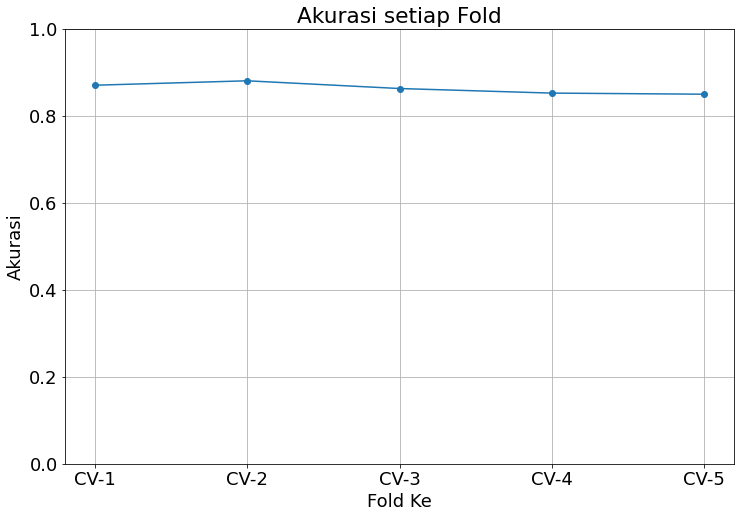

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(CV, akurasi_val_data, marker='o')
plt.title('Akurasi setiap Fold')
plt.xlabel('Fold Ke')
plt.ylabel('Akurasi')
plt.ylim((0., 1))
plt.grid()
plt.show()

In [ ]:
def visualisasi_fit(judul, n_train, n_val):
  fig, ax = plt.subplots(3,2,constrained_layout=True, figsize=(15,10))
  index=0
  for i in range(3):
    for j in range(2):
      if j==0:
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
      else:
        if index==5:
          break
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
      ax[i,j].grid()
      ax[i,j].set_ylim((0., 1))
      ax[i,j].legend()
      index+=1

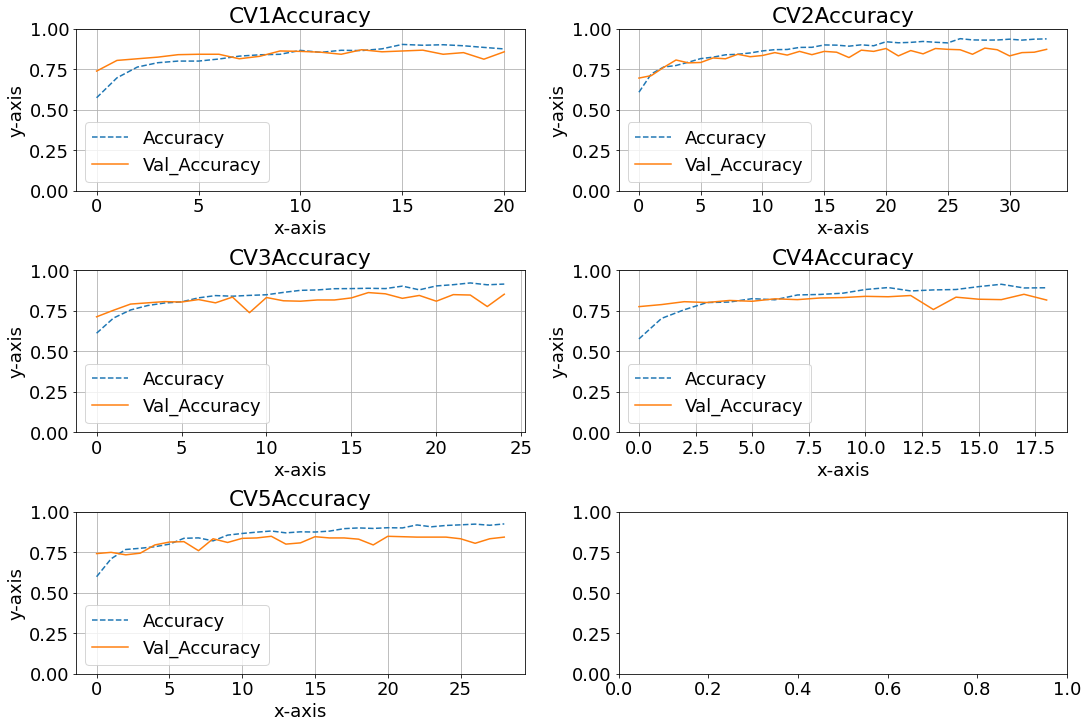

In [ ]:
vis_akurasi = visualisasi_fit('Accuracy', ACCURACY, VAL_ACCURACY)
vis_akurasi

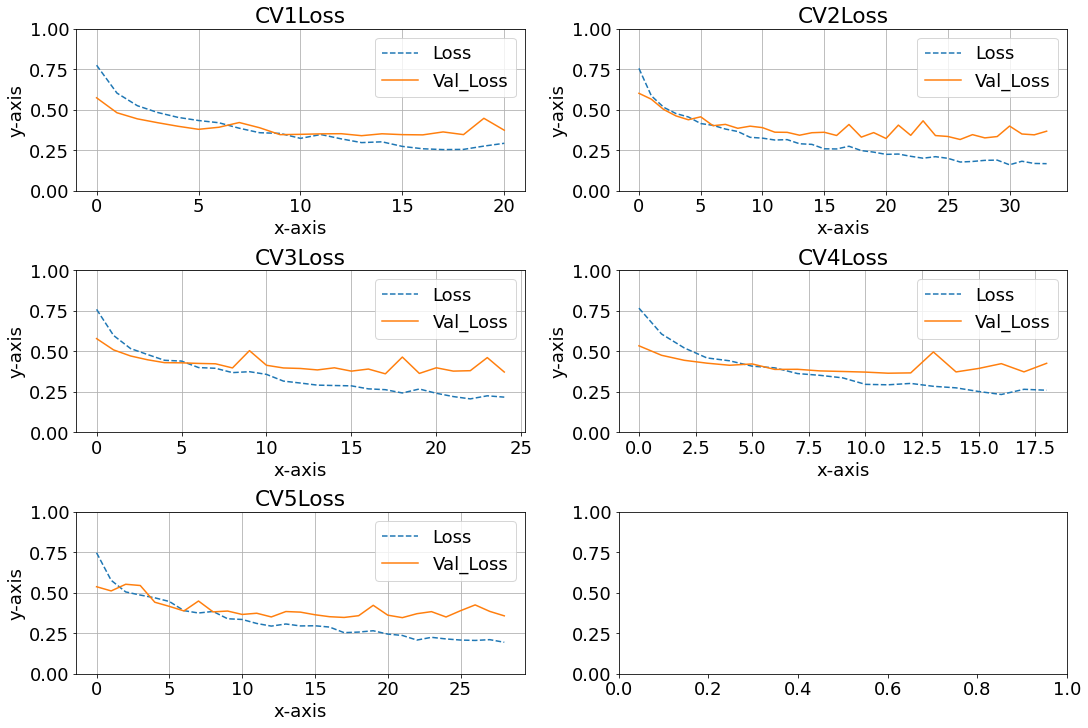

In [ ]:
vis_loss = visualisasi_fit('Loss', LOSS, VAL_LOSS)
vis_loss

In [ ]:
terbaik=[]
for i in range(5):
  nilai = (akurasi_val_data[i]+AUC[i])/2
  terbaik.append(nilai)

In [ ]:
terbaik

[0.8705583756345178,
 0.8807106598984771,
 0.8629441624365481,
 0.8523909263399241,
 0.8499273222289265]

In [ ]:
s=0
baik=1
for i, v in enumerate(terbaik):
  if v>s:
    s=v
    baik=i+1
  else:
    continue
print(baik, s)

2 0.8807106598984771


In [ ]:
model = load_model(save_dir+"model_"+str(baik))
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

16/16 [==============================] - 4s 264ms/step


In [ ]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
f1score_test = f1_score(y_test, y_pred)

In [ ]:
print('Acc Test : ', acc_test)
print('Prec Test : ', prec_test)
print('Rec Test : ', rec_test)
print('F1-Score Test : ', f1score_test)

Acc Test :  0.8902439024390244
Prec Test :  0.8692307692307693
Rec Test :  0.9186991869918699
F1-Score Test :  0.8932806324110673


In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))

                   precision    recall  f1-score   support

Haploid (Class 0)       0.91      0.86      0.89       246
Diploid (Class 1)       0.87      0.92      0.89       246

         accuracy                           0.89       492
        macro avg       0.89      0.89      0.89       492
     weighted avg       0.89      0.89      0.89       492



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[212,  34],
       [ 20, 226]])

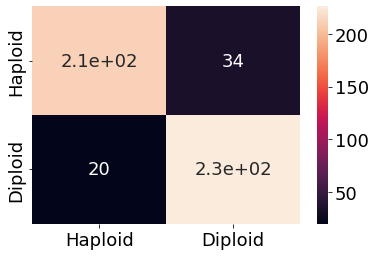

In [ ]:
sns.heatmap(cm, annot=True, xticklabels=['Haploid', 'Diploid'], yticklabels=['Haploid', 'Diploid'])

In [ ]:
def plot_roc_curve(true_y, y_prob): 
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Model AUC score : 0.8902439024390245


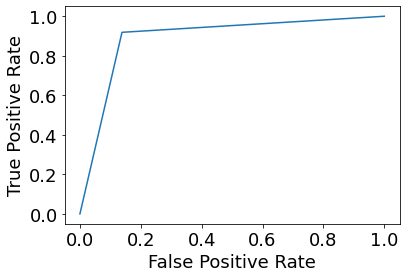

In [ ]:
plot_roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('Model AUC score : {}'.format(auc))

In [ ]:
x_test, y_test = get_data(path_benih + 'test/')

Loading /content/drive/My Drive/Penelitian/Dataset/test/haploid


100%|██████████| 246/246 [00:01<00:00, 142.44it/s]


Loading /content/drive/My Drive/Penelitian/Dataset/test/diploid


100%|██████████| 354/354 [00:02<00:00, 154.22it/s]


In [ ]:
x_test/=255.

In [ ]:
model = load_model(save_dir+"model_"+str(baik))
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

19/19 [==============================] - 3s 175ms/step


In [ ]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
f1score_test = f1_score(y_test, y_pred)

In [ ]:
print('Acc Test : ', acc_test)
print('Prec Test : ', prec_test)
print('Rec Test : ', rec_test)
print('F1-Score Test : ', f1score_test)

Acc Test :  0.9066666666666666
Prec Test :  0.907103825136612
Rec Test :  0.9378531073446328
F1-Score Test :  0.9222222222222222


In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))

                   precision    recall  f1-score   support

Haploid (Class 0)       0.91      0.86      0.88       246
Diploid (Class 1)       0.91      0.94      0.92       354

         accuracy                           0.91       600
        macro avg       0.91      0.90      0.90       600
     weighted avg       0.91      0.91      0.91       600



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[212,  34],
       [ 22, 332]])

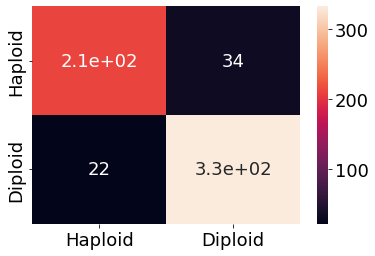

In [ ]:
sns.heatmap(cm, annot=True, xticklabels=['Haploid', 'Diploid'], yticklabels=['Haploid', 'Diploid'])

In [ ]:
def plot_roc_curve(true_y, y_prob): 
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Model AUC score : 0.8998208626154058


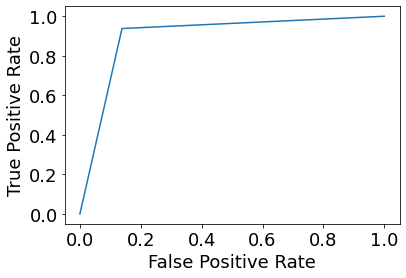

In [ ]:
plot_roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('Model AUC score : {}'.format(auc))